Let's implement the same Network in the PyTorch

In [22]:
import torch
from torchvision import transforms

In [23]:
from torchvision.datasets import MNIST

In [24]:
import torchvision.transforms as tfs
transformations = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [25]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=transformations, download=True)
test  = MNIST(root, train=False, transform=transformations, download=True)
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


In [26]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
val_data_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [27]:
class SimpleNet(torch.nn.Module):
  def __init__(self):
    super(SimpleNet, self).__init__()
    self.fc1 = torch.nn.Linear(784, 24)
    self.fc2 = torch.nn.Linear(24,15)
    self.fc3 = torch.nn.Linear(15,10)
  def forward(self, x):
    x = x.view(-1, 784)
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = self.fc3(x) # do not use softmax yet bcs our CrossEntropy cost function has it
    return x 
simplenet = SimpleNet()

optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.001)

# let's move to GPUs

if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=10, bias=True)
)

In [30]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(torch.nn.functional.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [31]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_loader,val_data_loader, epochs=5, device=device)

Epoch: 1, Training Loss: 0.37, Validation Loss: 0.34, accuracy = 0.90
Epoch: 2, Training Loss: 0.32, Validation Loss: 0.31, accuracy = 0.91
Epoch: 3, Training Loss: 0.30, Validation Loss: 0.29, accuracy = 0.91
Epoch: 4, Training Loss: 0.28, Validation Loss: 0.27, accuracy = 0.92
Epoch: 5, Training Loss: 0.26, Validation Loss: 0.25, accuracy = 0.92


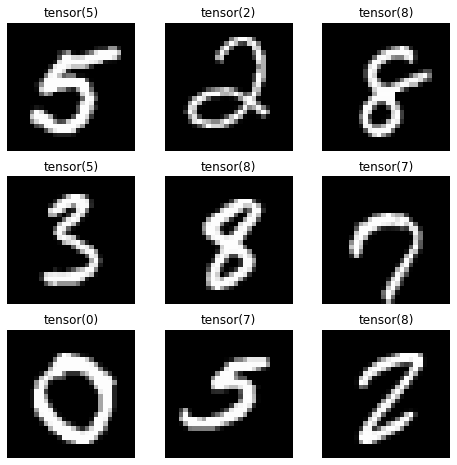

In [47]:
import matplotlib.pyplot as plt
labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}
cols, rows = 3, 3
figure = plt.figure(figsize=(8,8))
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test), size=(1,)).item()
    img, label = test[sample_idx]
    figure.add_subplot(rows, cols, i)
    prediction = torch.nn.functional.softmax(simplenet(img), dim=1)
    prediction = prediction.argmax()
    plt.title(prediction.get_item)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()